In [1]:
%load_ext autoreload
%autoreload 2

from vflow import Vset, build_vset, filter_vset_by_metric, init_args, dict_to_df, perturbation_stats

from vflow.pipeline import build_graph

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from functools import partial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.options.display.max_rows = 15
np.random.seed(31415)

In [2]:
X, y = make_classification(n_samples=1000, n_informative=10)

# 20% of X entries missing
i = np.random.randint(X.shape[0], size=round(X.shape[0]*X.shape[1] * 0.2))
j = np.random.randint(X.shape[1], size=i.size)
X[i, j] = np.nan

# 2% outliers
i = np.random.randint(X.shape[0], size=round(X.shape[0]*X.shape[1] * 0.02))
j = np.random.randint(X.shape[1], size=i.size)
X[i, j] = X[i, j]*75

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval)

X_train, y_train = init_args([X_train, y_train], names=['X_train', 'y_train'])
X_val, y_val = init_args([X_val, y_val], names=['X_val', 'y_val'])
X_trainval, y_trainval = init_args([X_trainval, y_trainval], names=['X_trainval', 'y_trainval'])
X_test, y_test = init_args([X_test, y_test], names=['X_test', 'y_test'])

In [3]:
rf = RandomForestClassifier()
lr = LogisticRegression()
mlp = MLPClassifier()
dt = DecisionTreeClassifier()

In [4]:
resample_set = Vset('resample', [partial(resample, n_samples=50) for i in range(10)])
impute_set = Vset('impute', [SimpleImputer(), SimpleImputer(strategy='median')], module_keys=['mean', 'median'], output_matching=True)
model_set = Vset('model', [rf, lr, dt], module_keys=['rf', 'lr', 'dt'])

def accuracy_score_proba(y_true, y_pred_proba):
    ''' like accuracy_score, but y_pred is output from predict_proba
    '''
    return accuracy_score(y_true, np.argmax(y_pred_proba, axis=1))

def my_roc_auc_score(y_true, y_pred_proba):
    ''' like roc_auc_score, but y_pred is output from predict_proba
    '''
    return roc_auc_score(y_true, y_pred_proba[:, -1])

eval_set = Vset('eval', [accuracy_score_proba, my_roc_auc_score], module_keys=['acc', 'auroc'])

In [5]:
X_trains, y_trains = resample_set(X_train, y_train)
X_trains = impute_set.fit(X_trains).transform(X_trains)

In [6]:
model_set.fit(X_trains, y_trains)

/home/james/miniconda3/envs/vflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/james/miniconda3/envs/vflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [7]:
preds = model_set.predict_proba(impute_set.transform(X_val))
metrics = eval_set.evaluate(y_val, preds)

In [8]:
df_metrics = dict_to_df(metrics)
df_metrics

,init-resample,init-resample,init-resample,resample,impute,init-model,init-model,init-model,model,eval,out
0,y_val,X_val,X_train,resample_0,mean,X_train,X_train,y_train,rf,acc,0.744681
1,y_val,X_val,X_train,resample_1,mean,X_train,X_train,y_train,rf,acc,0.617021
2,y_val,X_val,X_train,resample_2,mean,X_train,X_train,y_train,rf,acc,0.734043
3,y_val,X_val,X_train,resample_3,mean,X_train,X_train,y_train,rf,acc,0.648936
4,y_val,X_val,X_train,resample_4,mean,X_train,X_train,y_train,rf,acc,0.680851
...,...,...,...,...,...,...,...,...,...,...,...
115,y_val,X_val,X_train,resample_5,median,X_train,X_train,y_train,dt,auroc,0.543488
116,y_val,X_val,X_train,resample_6,median,X_train,X_train,y_train,dt,auroc,0.676139
117,y_val,X_val,X_train,resample_7,median,X_train,X_train,y_train,dt,auroc,0.590083
118,y_val,X_val,X_train,resample_8,median,X_train,X_train,y_train,dt,auroc,0.669121


/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


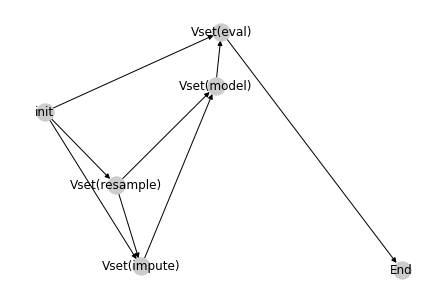

In [9]:
build_graph(metrics)

In [10]:
df_impute = perturbation_stats(metrics, 'eval', 'impute')
df_impute

,eval,impute,count,mean,std
0,acc,mean,30,0.644149,0.064519
1,acc,median,30,0.660461,0.055737
2,auroc,mean,30,0.687270,0.081864
3,auroc,median,30,0.705093,0.079879


In [11]:
mean_means = df_impute[df_impute['impute'] == 'mean']['mean'].to_numpy()
mean_stds = df_impute[df_impute['impute'] == 'mean']['std'].to_numpy()
median_means = df_impute[df_impute['impute'] == 'median']['mean'].to_numpy()
median_stds = df_impute[df_impute['impute'] == 'median']['std'].to_numpy()

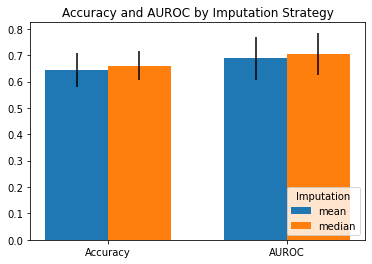

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ind = np.arange(2)    # the x locations for the groups
width = 0.35         # the width of the bars

ax.bar(ind, mean_means, width, bottom=0, yerr=mean_stds, label='mean')
ax.bar(ind + width, median_means, width, bottom=0, yerr=median_stds, label='median')

ax.set_title('Accuracy and AUROC by Imputation Strategy')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Accuracy', 'AUROC'])

ax.legend(loc='lower right', title='Imputation')
ax.autoscale_view()

plt.show()

In [13]:
df_impute_model = perturbation_stats(metrics, 'model', 'eval', 'impute')
df_impute_model

,model,eval,impute,count,mean,std
0,dt,acc,mean,10,0.596277,0.054962
1,dt,acc,median,10,0.624468,0.059612
2,dt,auroc,mean,10,0.602911,0.047092
3,dt,auroc,median,10,0.630672,0.054265
4,lr,acc,mean,10,0.655319,0.045329
5,lr,acc,median,10,0.667553,0.036873
6,lr,auroc,mean,10,0.681431,0.030701
7,lr,auroc,median,10,0.691797,0.032030
8,rf,acc,mean,10,0.680851,0.064467
9,rf,acc,median,10,0.689362,0.051705


In [14]:
dt_mean_means = df_impute_model[(df_impute_model['impute'] == 'mean') & (df_impute_model['model'] == 'dt')]['mean'].to_numpy()
dt_mean_stds = df_impute_model[(df_impute_model['impute'] == 'mean') & (df_impute_model['model'] == 'dt')]['std'].to_numpy()
dt_median_means = df_impute_model[(df_impute_model['impute'] == 'median') & (df_impute_model['model'] == 'dt')]['mean'].to_numpy()
dt_median_stds = df_impute_model[(df_impute_model['impute'] == 'median') & (df_impute_model['model'] == 'dt')]['std'].to_numpy()

rf_mean_means = df_impute_model[(df_impute_model['impute'] == 'mean') & (df_impute_model['model'] == 'rf')]['mean'].to_numpy()
rf_mean_stds = df_impute_model[(df_impute_model['impute'] == 'mean') & (df_impute_model['model'] == 'rf')]['std'].to_numpy()
rf_median_means = df_impute_model[(df_impute_model['impute'] == 'median') & (df_impute_model['model'] == 'rf')]['mean'].to_numpy()
rf_median_stds = df_impute_model[(df_impute_model['impute'] == 'median') & (df_impute_model['model'] == 'rf')]['std'].to_numpy()

lr_mean_means = df_impute_model[(df_impute_model['impute'] == 'mean') & (df_impute_model['model'] == 'lr')]['mean'].to_numpy()
lr_mean_stds = df_impute_model[(df_impute_model['impute'] == 'mean') & (df_impute_model['model'] == 'lr')]['std'].to_numpy()
lr_median_means = df_impute_model[(df_impute_model['impute'] == 'median') & (df_impute_model['model'] == 'lr')]['mean'].to_numpy()
lr_median_stds = df_impute_model[(df_impute_model['impute'] == 'median') & (df_impute_model['model'] == 'lr')]['std'].to_numpy()

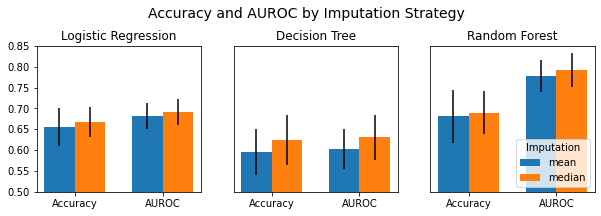

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)

fig.subplots_adjust(top=0.8)

fig.set_figheight(3)
fig.set_figwidth(10)

fig.suptitle('Accuracy and AUROC by Imputation Strategy', fontsize=14)

ind = np.arange(2)    # the x locations for the groups
width = 0.35         # the width of the bars

axs[0].bar(ind, lr_mean_means, width, bottom=0, yerr=lr_mean_stds, label='mean')
axs[0].bar(ind + width, lr_median_means, width, bottom=0, yerr=lr_median_stds, label='median')
axs[0].set_title('Logistic Regression')

axs[1].bar(ind, dt_mean_means, width, bottom=0, yerr=dt_mean_stds, label='mean')
axs[1].bar(ind + width, dt_median_means, width, bottom=0, yerr=dt_median_stds, label='median')
axs[1].set_title('Decision Tree')
axs[1].get_yaxis().set_visible(False)

axs[2].bar(ind, rf_mean_means, width, bottom=0, yerr=rf_mean_stds, label='mean')
axs[2].bar(ind + width, rf_median_means, width, bottom=0, yerr=rf_median_stds, label='median')
axs[2].set_title('Random Forest')
axs[2].get_yaxis().set_visible(False)
axs[2].legend(loc='lower right', title='Imputation')

for ax in axs:
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(['Accuracy', 'AUROC'])
    ax.set_ylim([0.5, 0.85])

plt.show()

In [16]:
perturbation_stats(df_metrics[df_metrics['eval'].isin(['acc'])], 'model', 'eval', 'impute').sort_values('mean', ascending=False)

,model,eval,impute,count,mean,std
5,rf,acc,median,10,0.689362,0.051705
4,rf,acc,mean,10,0.680851,0.064467
3,lr,acc,median,10,0.667553,0.036873
2,lr,acc,mean,10,0.655319,0.045329
1,dt,acc,median,10,0.624468,0.059612
0,dt,acc,mean,10,0.596277,0.054962


In [17]:
best_impute_set, best_model_set = \
    filter_vset_by_metric(metrics, impute_set, model_set, n_keep=2, filter_on=['acc'], group=True)
print(best_impute_set.modules)
print(best_model_set.modules)

{(mean,): <vflow.vfunc.Vfunc object at 0x7efbe1d28d30>, (median,): <vflow.vfunc.Vfunc object at 0x7efbe1d28e50>}
{(rf,): <vflow.vfunc.Vfunc object at 0x7efbe1d28ac0>}


In [18]:
best_impute_set.__prev__

((<vflow.vset.Vset at 0x7efbe1d28d00>,
  ('init',),
  (<vflow.vset.Vset at 0x7efbe1be7340>,
   (<vflow.vset.Vset at 0x7efc175eef40>, ('init',)))),
 <vflow.vset.Vset at 0x7efc175eef40>)

/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


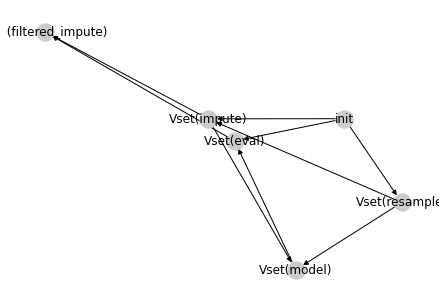

In [19]:
build_graph(best_impute_set)

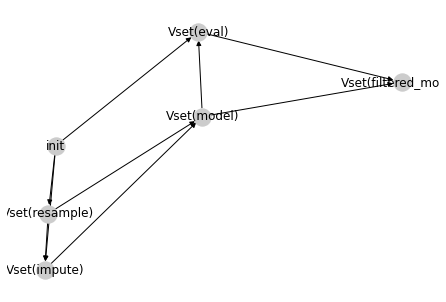

In [20]:
build_graph(best_model_set)

In [21]:
X_trainval = best_impute_set.fit(X_trainval).transform(X_trainval)
best_impute_set.__prev__

((<vflow.vset.Vset at 0x7efbe1d28d00>,
  ('init',),
  (<vflow.vset.Vset at 0x7efbe1be7340>,
   (<vflow.vset.Vset at 0x7efc175eef40>, ('init',)))),
 ('init',))

In [22]:
best_model_set.fit(X_trainval, y_trainval)

/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


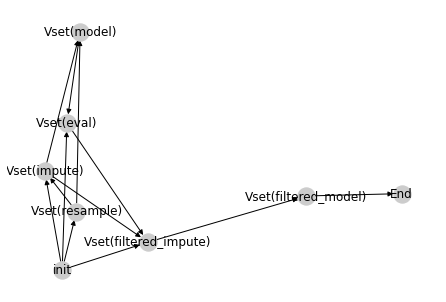

In [23]:
test_preds = best_model_set.predict_proba(best_impute_set.transform(X_test))
build_graph(test_preds)

In [24]:
test_metrics = eval_set.evaluate(y_test, test_preds)
dict_to_df(test_metrics)[['impute', 'model', 'eval', 'out']].sort_values(['eval', 'out'], ascending=False)

,impute,model,eval,out
3,median,rf,auroc,0.925339
2,mean,rf,auroc,0.923163
1,median,rf,acc,0.860000
0,mean,rf,acc,0.848000


In [25]:
dict_to_df(test_metrics)

,init-impute,init-impute,init-impute,impute,init-model,init-model,init-model,model,eval,out
0,y_test,X_test,X_trainval,mean,X_trainval,X_trainval,y_trainval,rf,acc,0.848000
1,y_test,X_test,X_trainval,median,X_trainval,X_trainval,y_trainval,rf,acc,0.860000
2,y_test,X_test,X_trainval,mean,X_trainval,X_trainval,y_trainval,rf,auroc,0.923163
3,y_test,X_test,X_trainval,median,X_trainval,X_trainval,y_trainval,rf,auroc,0.925339


/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


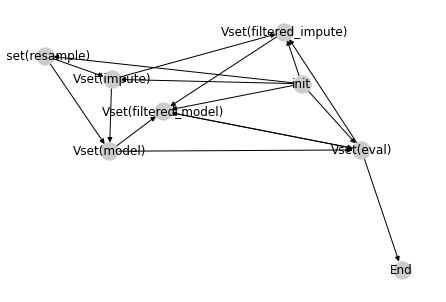

In [26]:
build_graph(test_metrics)